# Endothelial lineage - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)

luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataOF = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataOF@assays$RNA@counts@i + 1)
    anndataOF = subset(anndataOF, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataOF)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( 'somatic progenitor' = c('WT1', 'NR5A1'),
                'supporting lineage' = c('WNT6', 'WIPF3', 'GATA4'),
                'coelomic epi' = c('LRRN4', 'UPK3B', 'KLK11'),
                sLGR5 = c('LGR5', 'TSPAN8', 'CXCR4'),
                sPAX8 = c('PAX8', 'PLAU', 'CXCL12', 'CXCL14', 'SLIT1', 'SLIT2'),
                OSE= c('LHX9', 'LHX2', 'CALB2'),
                'pre-granulosa' = c( "KITLG", 'CSRNP1', 'CYP26B1', 'RSPO1', 'WNT4', 'FOXL2',  'OSR1', 'IRX3', 'CYP19A1',  'NOTCH3',  'HEYL', 'PROK1', 'RDH10', 'BMP2'),
                'WNT/beta-catenin' = c('AXIN2', 'WISP2', 'WIF1'),
                Sertoli = c('SOX9',  'AMH', 'INHBB', 'CITED1', 'CLDN11', 'WFDC2', 'CTNNA2'),
                'Fetal Leydig' = c('FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'CYP17A1'),
                mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [5]:
# # Remove CCG
# ccgs = read.csv('figures_manual_annotation/cell_cycle_genes.csv', stringsAsFactors = F)$X0
# anndata = subset(anndata, features = setdiff(allgenes, ccgs) )

In [6]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$seurat_clusters_v0 = meta$seurat_clusters[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$TP = meta$TP[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [7]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Endothelial')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
all(clusters_of_interest %in% anndata@meta.data$clusters)
table(anndata@meta.data$clusters)

An object of class Seurat 
28230 features across 10568 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

[1] TRUE


Endothelial 
      10568 

In [8]:
# Remove lowQC and doublets from previous round
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/endothelial_doublets_annotation.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_previous = 'new'
anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

table(anndata@meta.data$clusters_previous)


   arterial     cycling     doublet fenestrated   lymphatic      venous 
        772         927        1179        2578         724        4388 

In [9]:
# subset datasets to contain clusters of interest and remove doublets
# subset datasets to contain clusters of interest and remove doublets
clusters2remove = c(grep('doublet', anndata@meta.data$clusters_previous, value = T),
                    grep('cycling', anndata@meta.data$clusters_previous, value = T),
                    grep('new', anndata@meta.data$clusters_previous, value = T),
                    grep('lowQC', anndata@meta.data$clusters_previous, value = T))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, ! clusters_previous %in% clusters2remove)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
table(anndata@meta.data$clusters_previous)

An object of class Seurat 
28230 features across 8462 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)


   arterial fenestrated   lymphatic      venous 
        772        2578         724        4388 

In [10]:
# anndata = downsample_data(anndata, 'clusters_previous', N = 1000)

In [11]:
# basic gene/cell filtering
message('Removing ', sum(anndata@meta.data$nCount_RNA < 500), ' cells with less than 500 nCount_RNA' )
anndata <- subset(anndata, cells = colnames(anndata)[ anndata@meta.data$nCount_RNA >= 500 ] )
                    
gene_counts = tabulate(anndata@assays$RNA@counts@i+1)
message('Removing ', sum(gene_counts <= 3), ' genes expressed in 3 or less cells' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )

Removing 0 cells with less than 500 nCount_RNA

Removing 8928 genes expressed in 3 or less cells



In [12]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
28230 features across 8462 samples within 1 assay 
Active assay: RNA (28230 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  E2F8, CDC25C, RAD51, GAS2L3, AURKA, CKAP2L, TTK, PSRC1, HJURP, HMMR 
	   KIF11, NEK2, AURKB, CDCA2, CENPA, DLGAP5, NCAPD2, G2E3, CDCA3, KIF23 
	   UBR7, RRM2, CDCA8, NDC80, DSCC1, ECT2, GTSE1, KIF2C, CTCF, LBR 
Negative:  TYMS, GINS2, MCM5, UHRF1, MCM2, MCM4, MCM6, NASP, CDCA7, CLSPN 
	   HELLS, PCNA, RAD51AP1, CDC45, CKS1B, RRM1, ATAD2, CBX5, CENPF, FEN1 
	   RFC2, CDC6, TOP2A, CKS2, SMC4, 

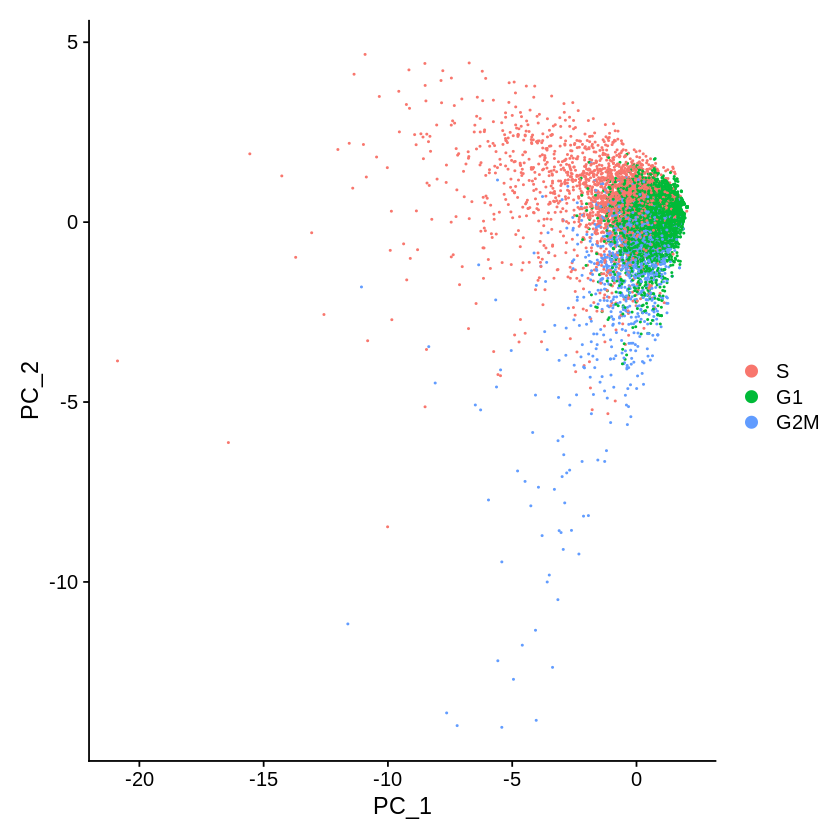

In [13]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [14]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  SPARC, A2M, IGFBP2, SPARCL1, IGF2-1, RBP7, SOX17, RNASE1, TAGLN2, SPP1 
	   EPAS1, MYL9, CD93, IL32, GPIHBP1, IL11RA, CXCR4, IGFBP3, WT1, THY1 
	   ECM1, VWF, C1orf115, PRND, RGS3, COL15A1, PALMD, APOA1, MECOM, ARHGDIB 
Negative:  CCL21, TFF3, PROX1, STAB2, MMRN1, RELN, NTS, PTX3, NUPR1, NR2F1 
	   PDPN, TFPI, MPP7, TBX1, PARD6G, SEMA3A, RAB11FIP1, IGF1, STON2, GJA1 
	   CTSL, PGM5, ADD3, ARL4A, SPHK1, PKHD1L1, CXADR, ACTN1, KBTBD11, TNFRSF11A 
PC_ 2 
Positive:  FBLN5, GJA5, GJA4, EGFL8, SEMA3G, AQP1, SERPINE2, TSPAN2, IGFBP3, PRND 
	   MECOM, SLC14A1, CD9, VEGFC, CXCL12, CXCR4, KCTD12, PDLIM1, UNC5B, GRIA2 
	   FBLN2, CLDN5, JAG1, SYNJ2, SRGN, HEY1, FBN1, GPIHBP1, HES4, CGNL1 
Negative:  APLNR, ITM2A, RPS4Y1, ECM1, SPP1, RPL26, NRP2, COTL1, RPL36A, RPL41 
	   OIT3, ISLR, TESC, RPS29, NNAT, DPEP1, DNASE1L3, HMGA1, PRKCB, RBP5 
	   CRHBP, RAMP3, RPL17, PIM3, FTH1, NT5E, EDIL3, SNAI2, BEX1, PCDH17 
PC_ 3 
Positive:  PLVAP, FN1, PLAT, NET1, FLT1, LRRC32, EDN1, CTSC, EDIL

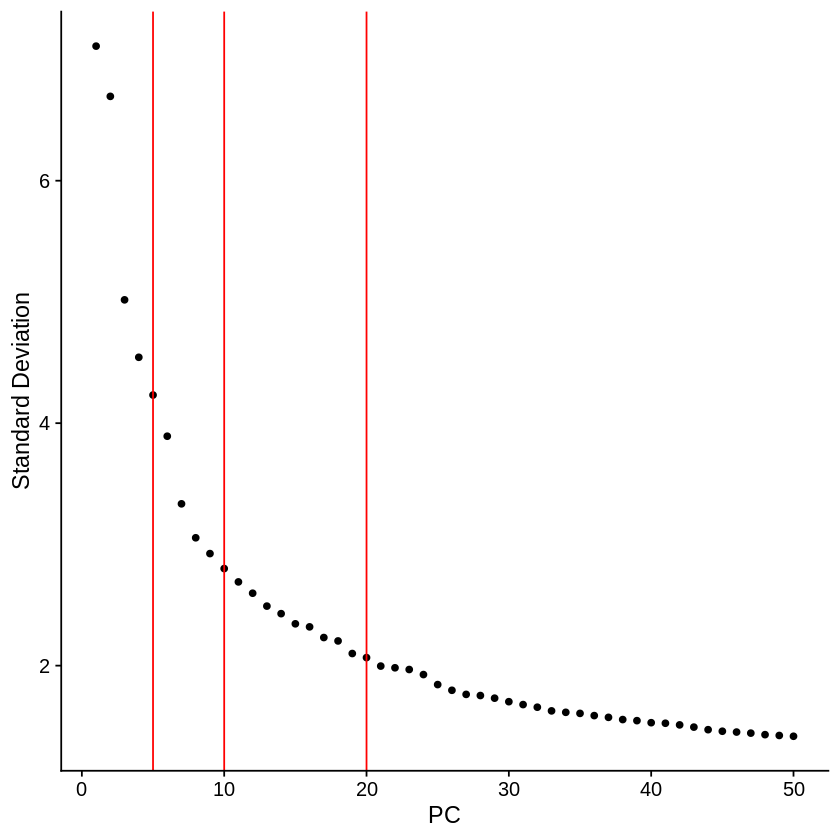

In [15]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [16]:
npca = 6
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0, lambda = 10, max.iter.harmony = 30, max.iter.cluster = 30)#, max.iter.harmony = 30, reference_values = c('Hrv3', 'Hrv58')) # sigma=0.2,

Harmony 1/30

Harmony 2/30

Harmony 3/30

Harmony 4/30

Harmony 5/30

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [17]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [18]:
anndata <- FindClusters(anndata, resolution = 0.1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8462
Number of edges: 257179

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9475
Number of communities: 4
Elapsed time: 0 seconds


In [19]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



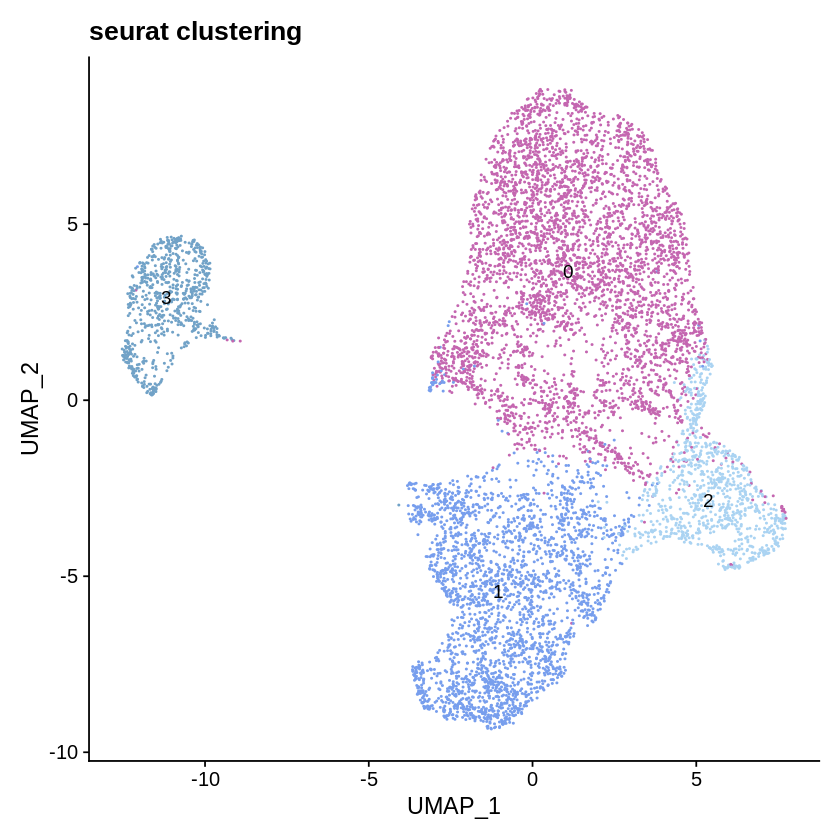

In [20]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-endothelial/cleanNocycling_umap_clustering.pdf'), dpi = 75)

Saving 13.3 x 13.3 in image



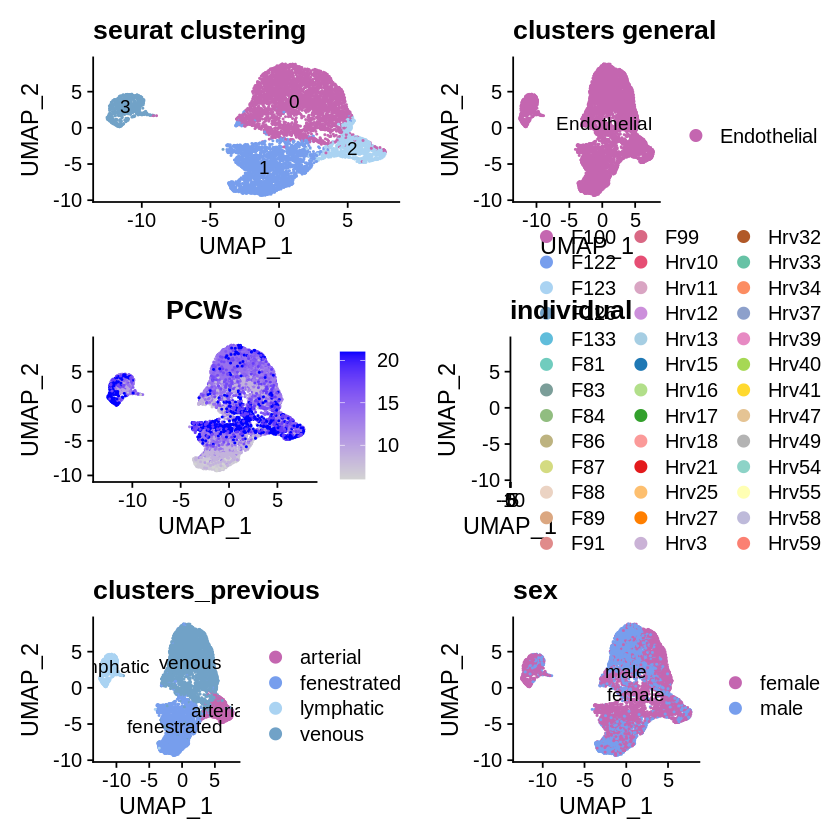

In [21]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_previous', label = T, cols = colors) + ggtitle('clusters_previous')
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T, cols = colors) + ggtitle('clusters general')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = p1b
p6 = DimPlot(anndata, reduction = "umap", group.by = 'sex',  label = T, cols = colors) + ggtitle('sex')
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 2)
ggsave(filename = paste0('figures-endothelial/cleanNocycling_umap_metadata.pdf'), scale = 2, dpi = 75)

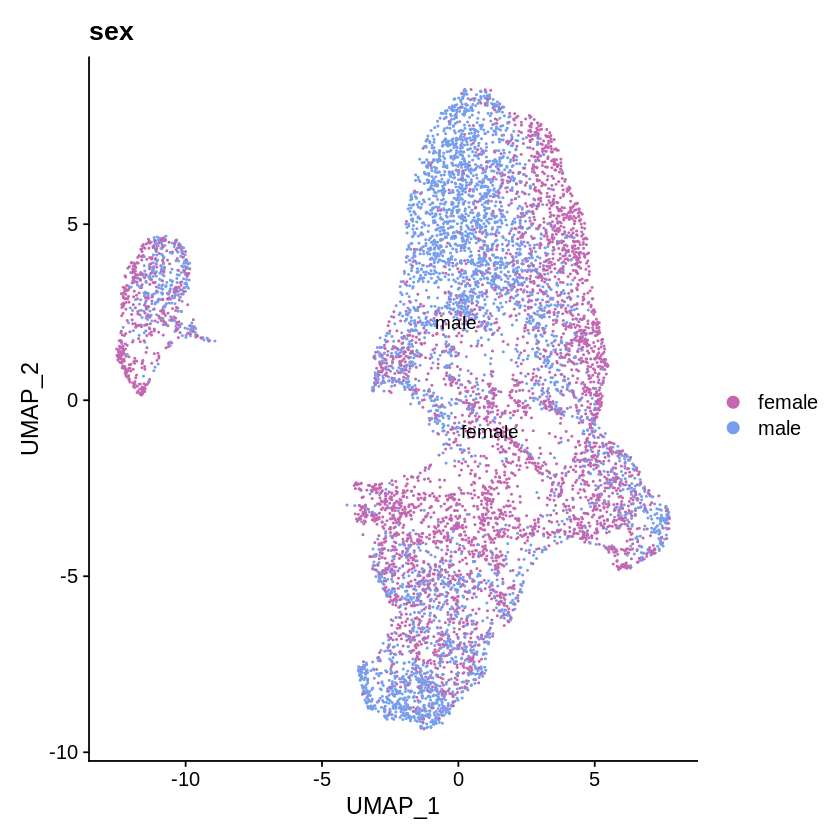

In [22]:
p6

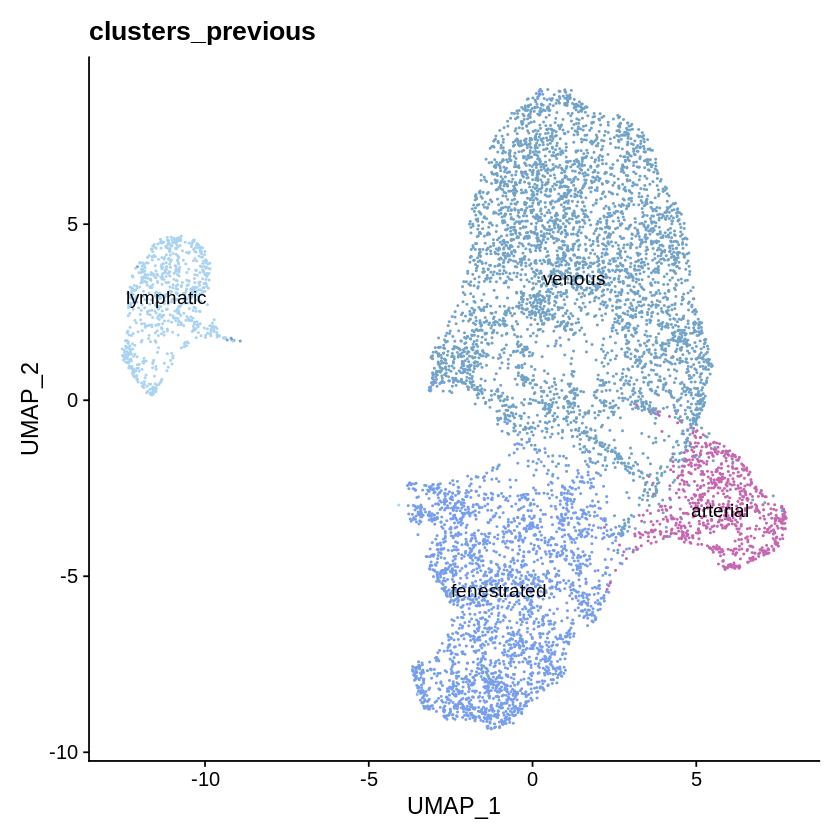

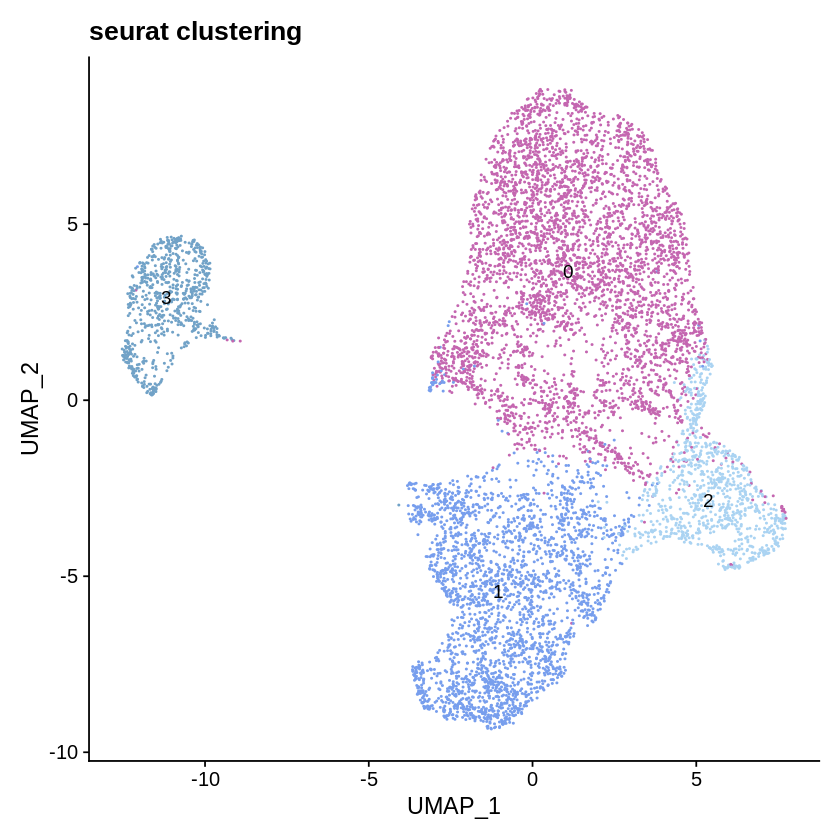

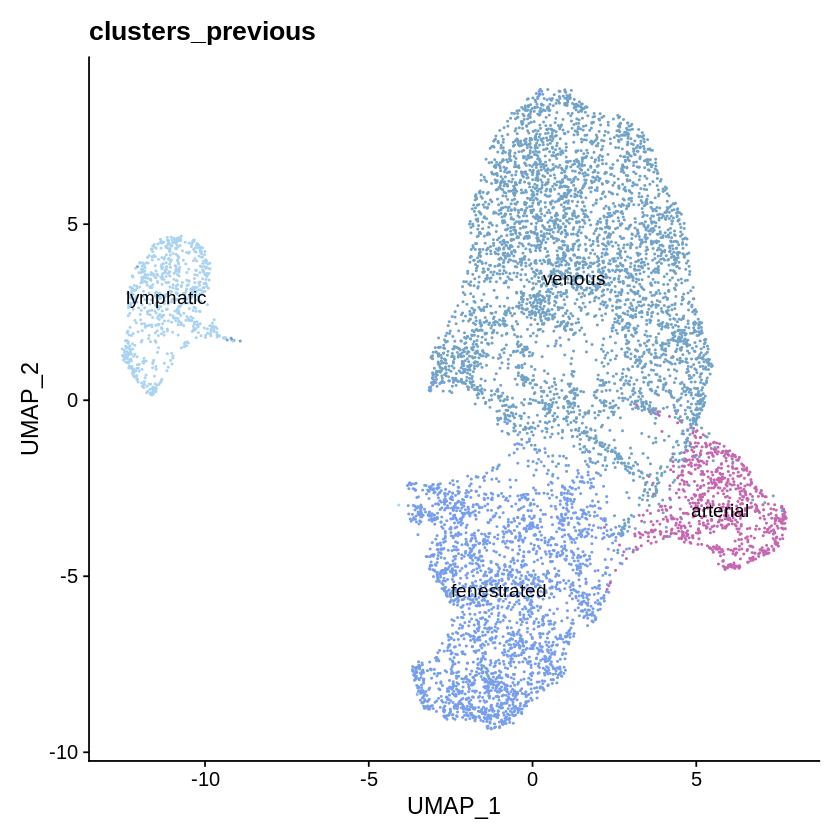

In [23]:
p1b + NoLegend()
p1
p5 + NoLegend()

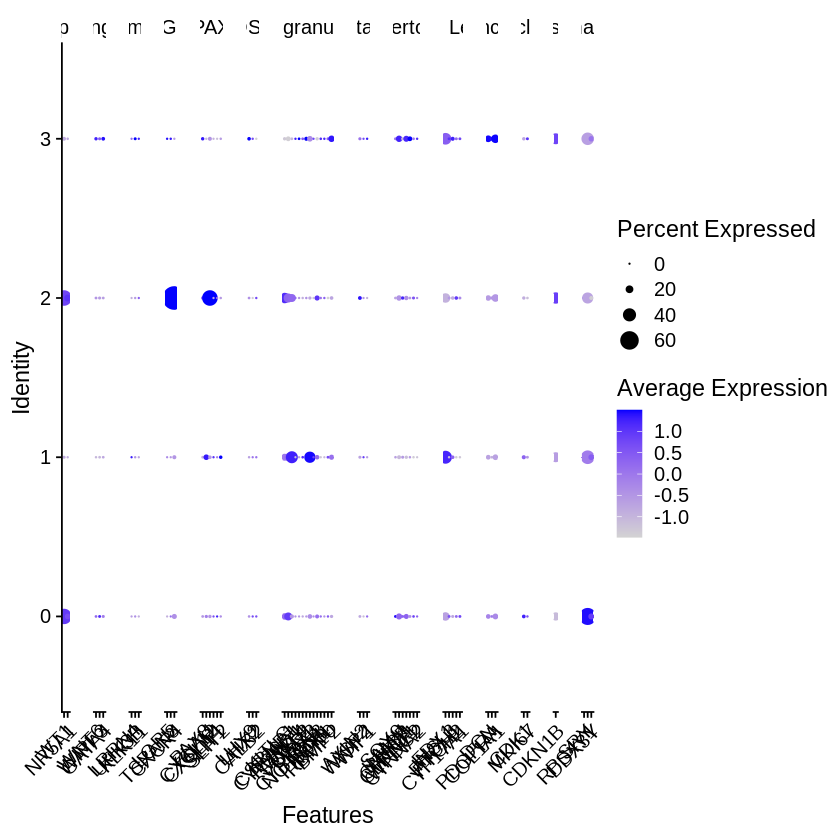

In [24]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_markers.pdf'), dpi = 75, height = 7, width = 30)

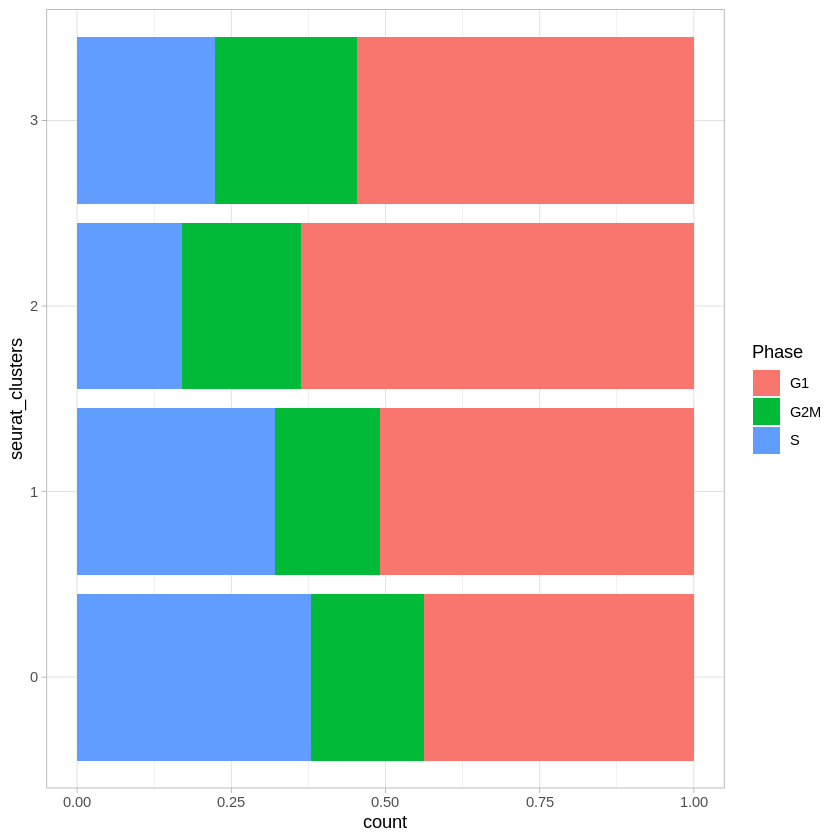

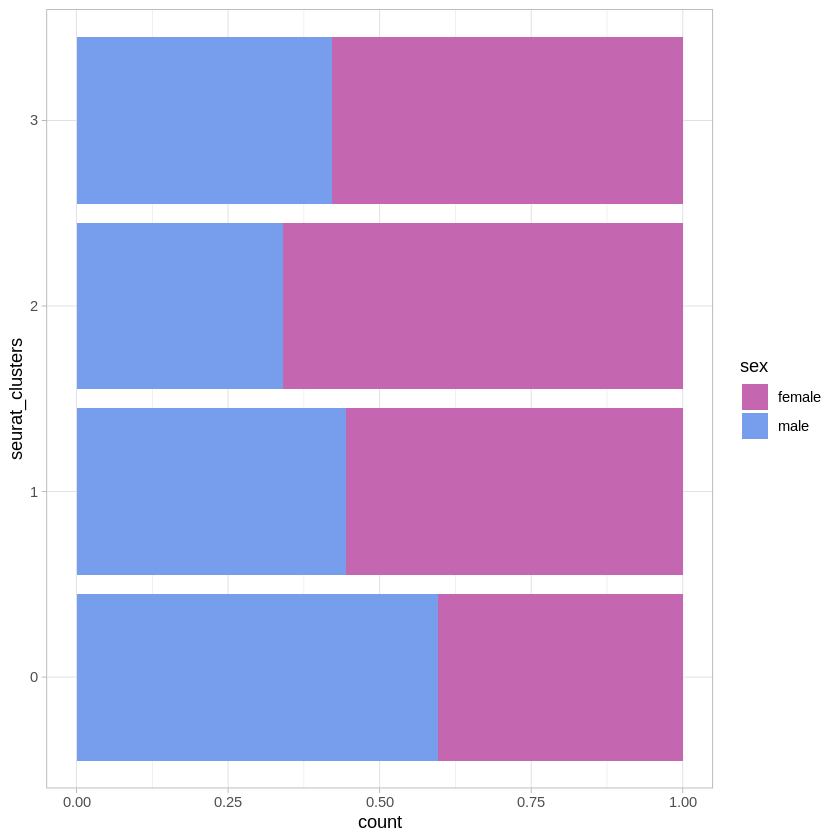

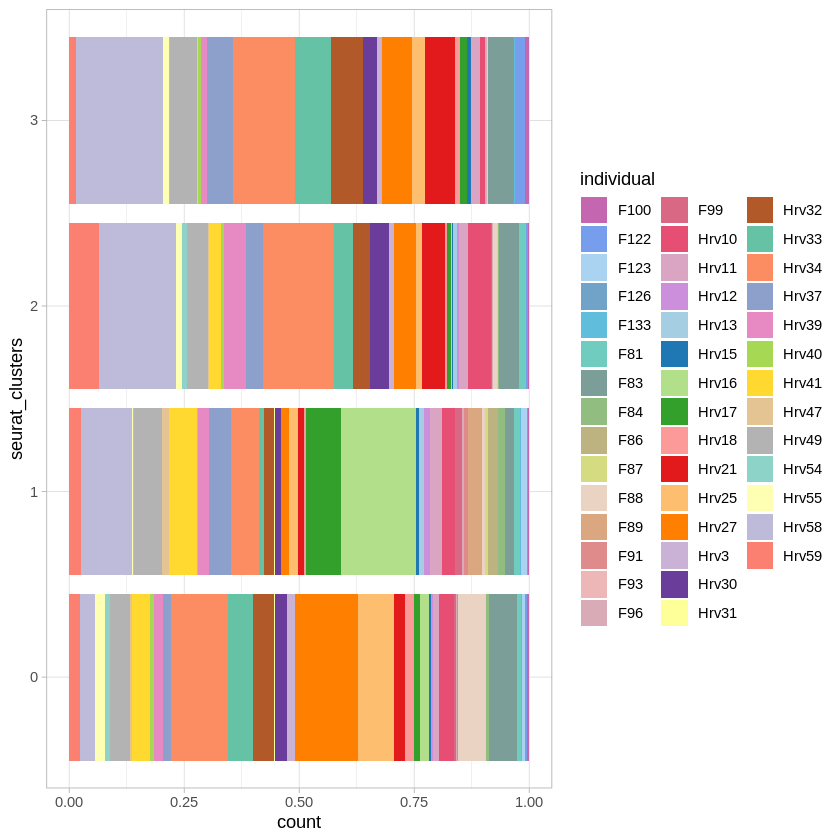

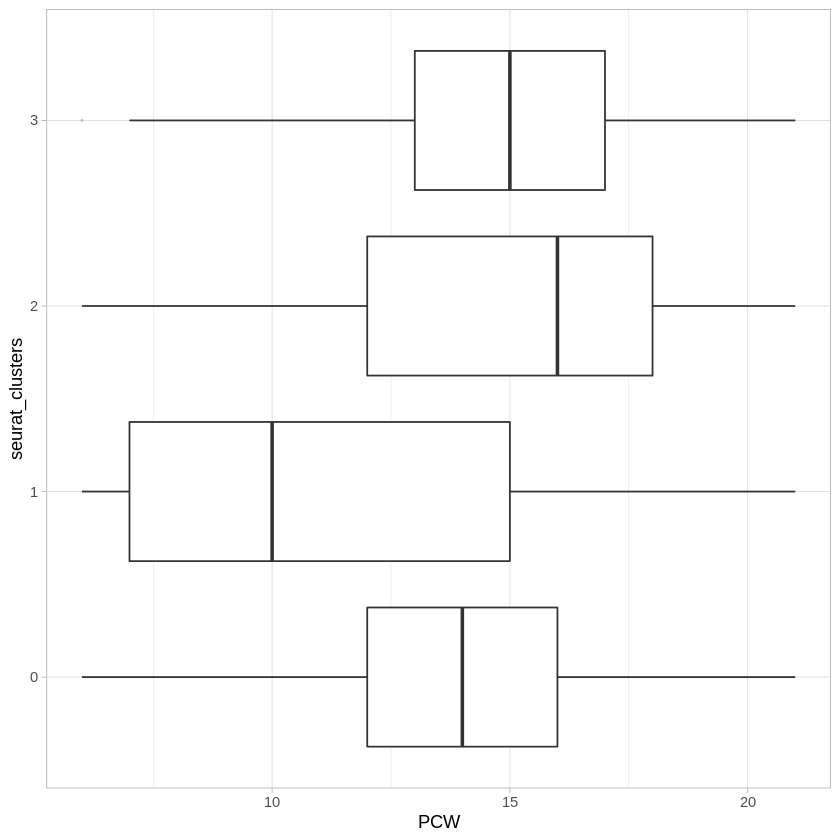

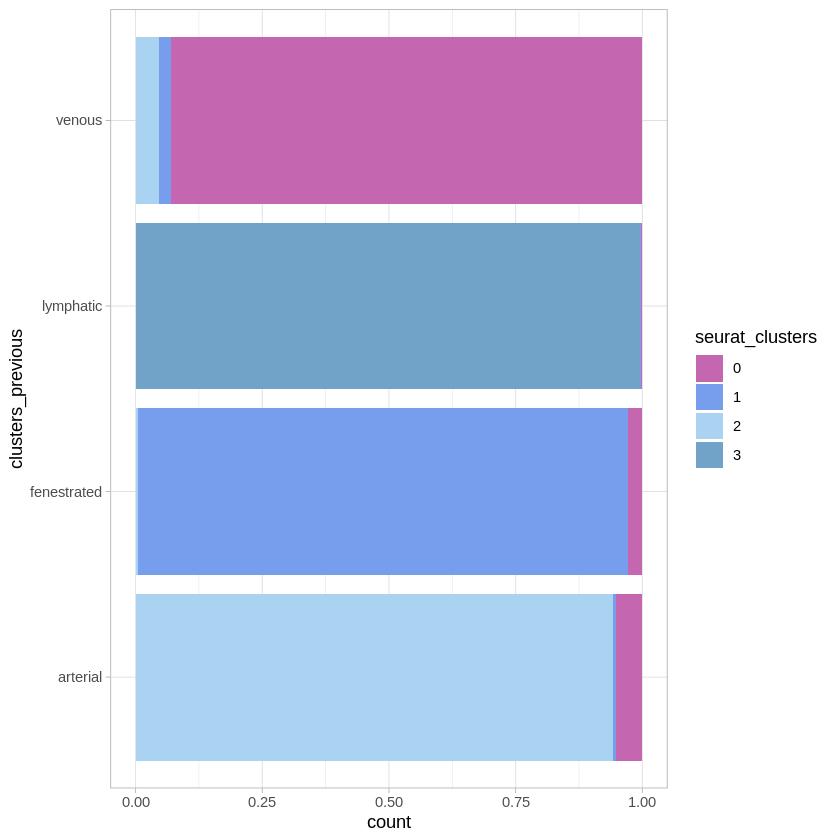

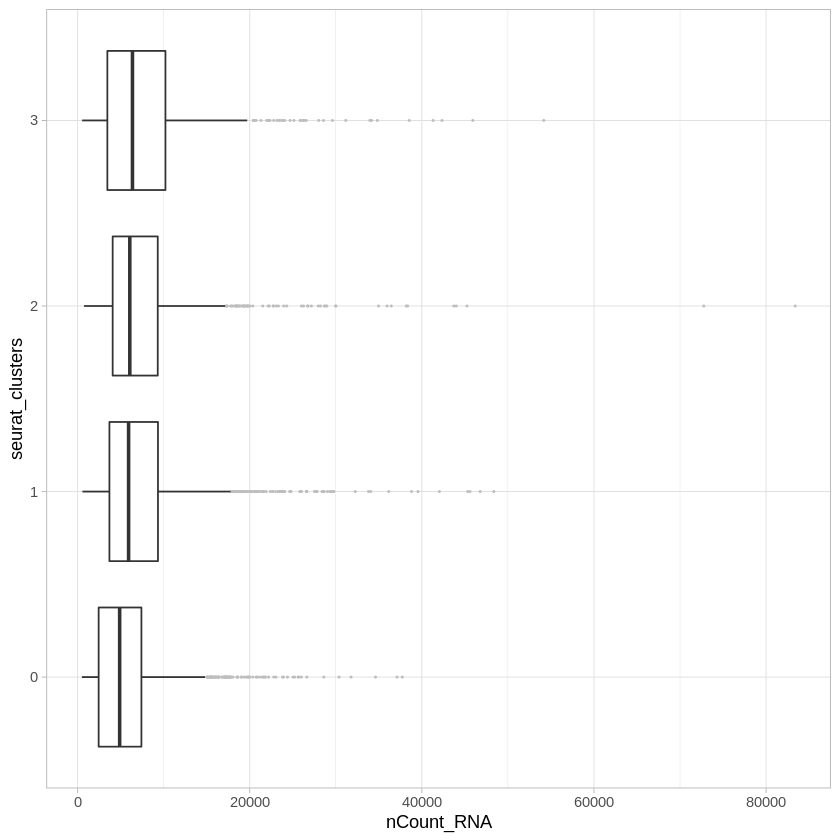

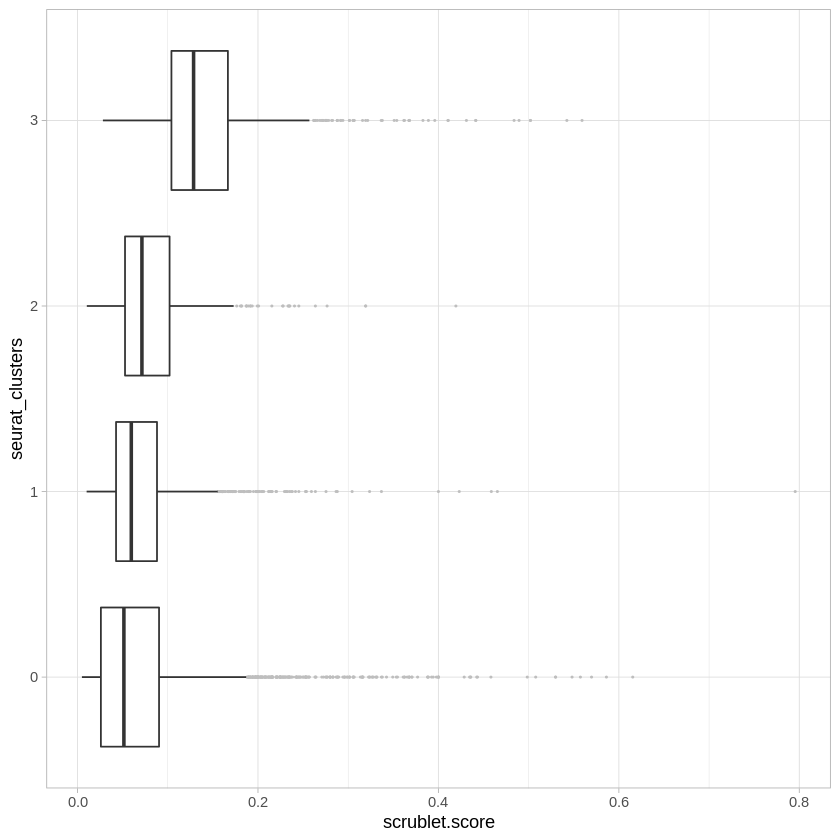

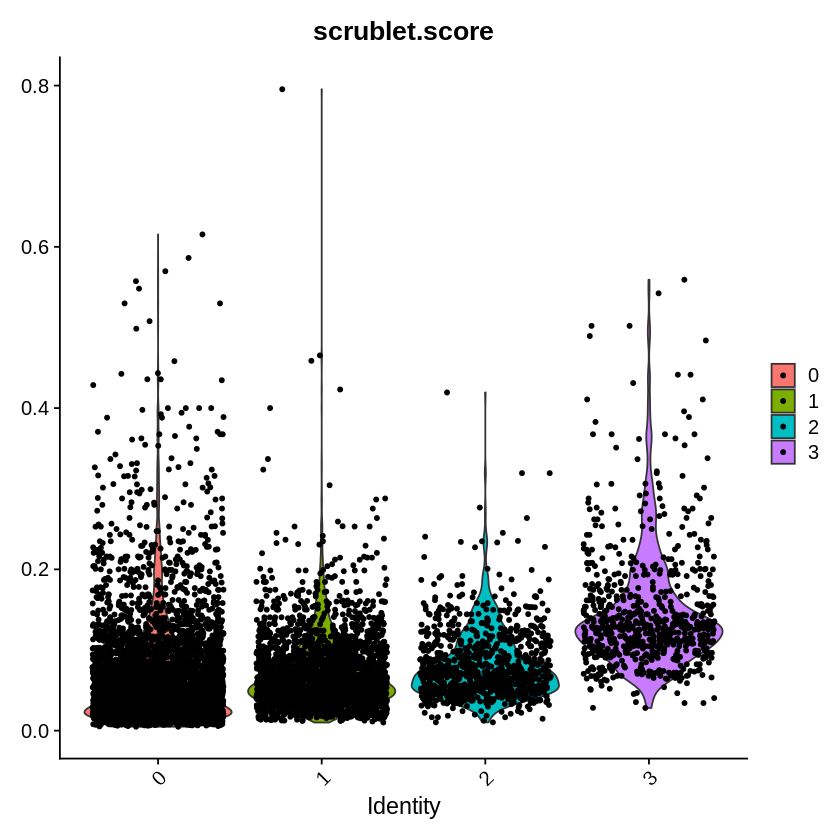

In [28]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()



ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()


ggplot(anndata@meta.data, aes(x =  clusters_previous, fill = seurat_clusters  )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndataO@meta.data, aes(x = seurat_clusters, y = nCount_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
ggplot(anndata@meta.data, aes(x = seurat_clusters, y = scrublet.score)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()

VlnPlot(anndata, 'scrublet.score')

### DEGs and GSA

In [30]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 20)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-endothelial/cleanNocycling_cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 80 10

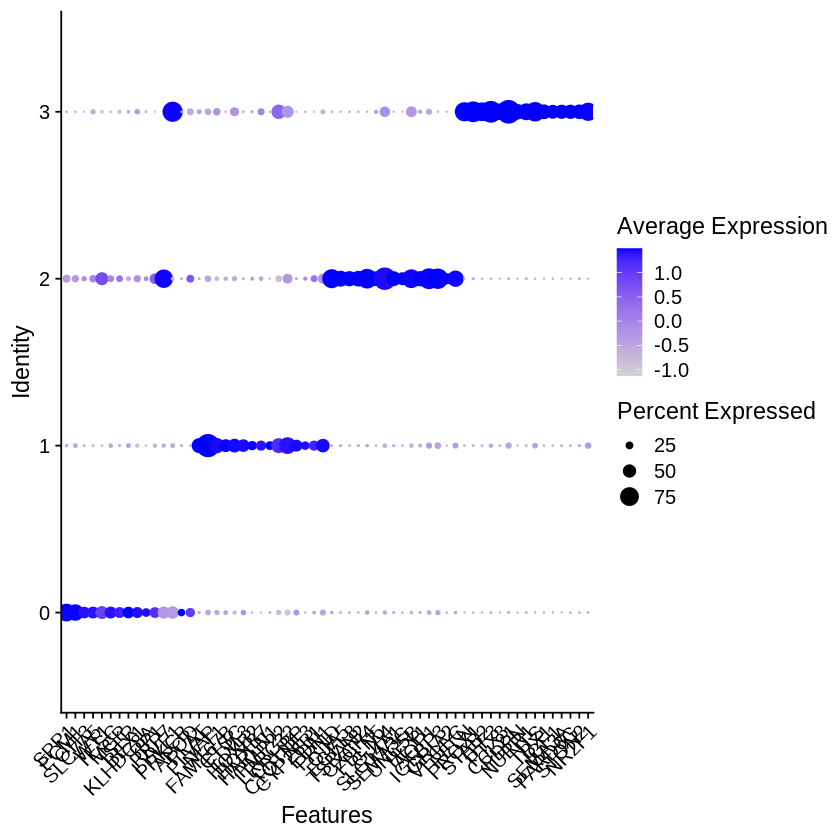

In [31]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 5, width = 45)

# Annotate clusters

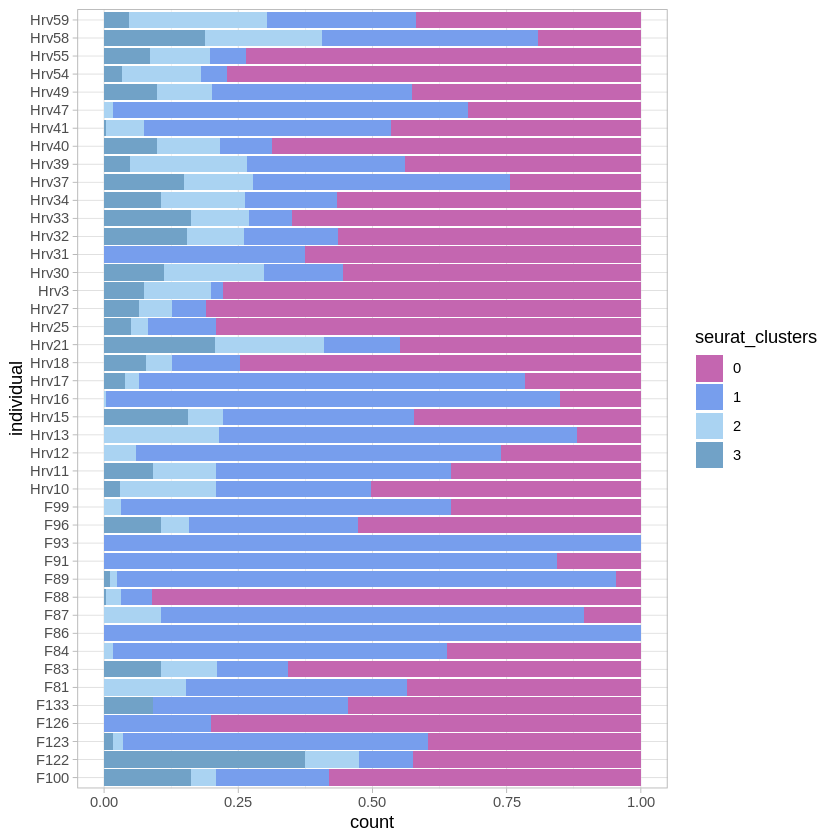

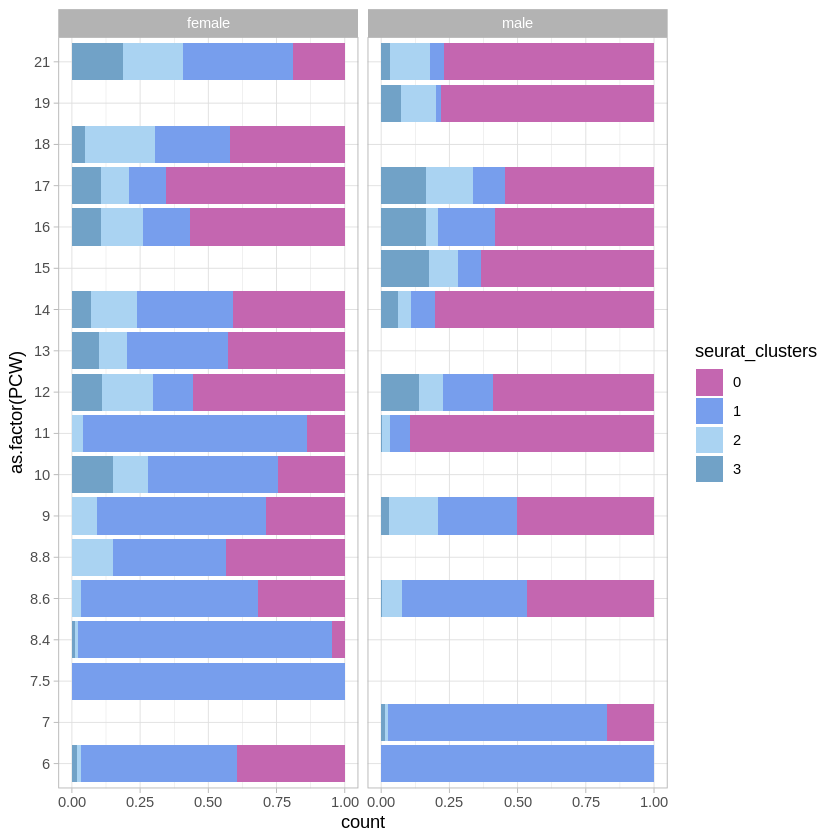

In [32]:
ggplot(anndata@meta.data, aes(x = individual , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

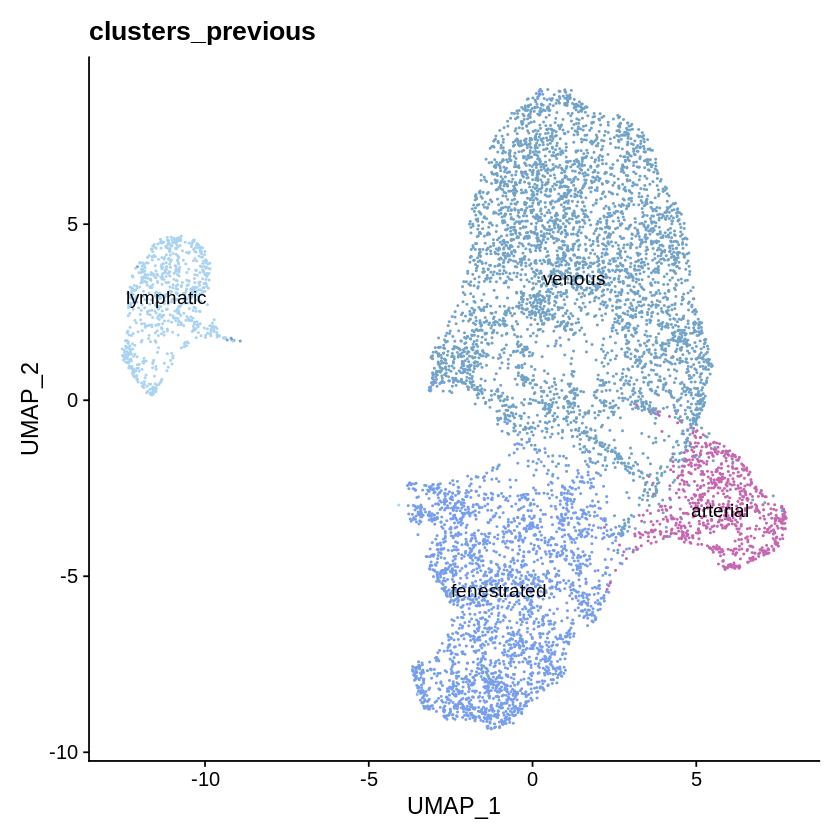

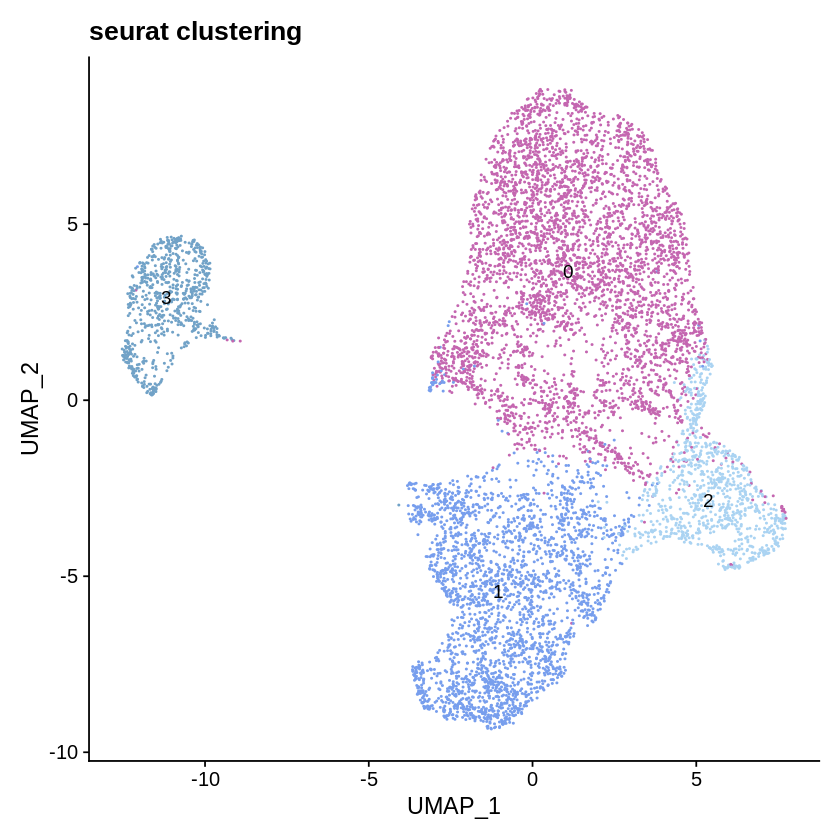

In [33]:
p1b + NoLegend()
p1

In [34]:
cluster_names = c('venous',#0
                 'fenestrated',
                 'arterial',
                 'lymphatic'
)



anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]


anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = unique(sort(cluster_names)))



anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = )


Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

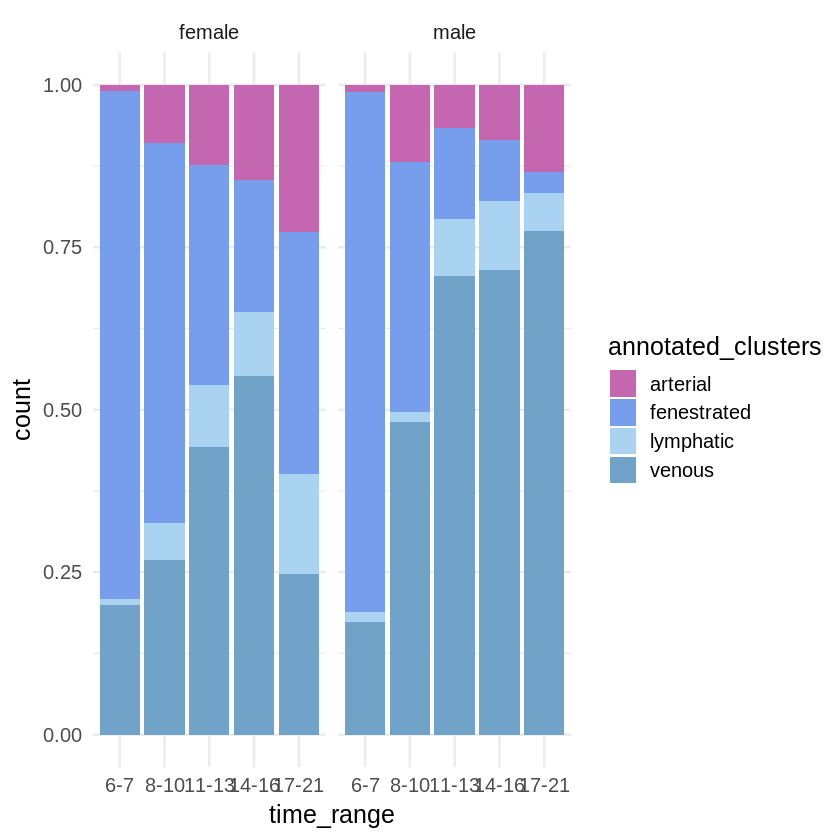

In [35]:
anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = luz_colors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
#     geom_bar()+
    theme_minimal(15)

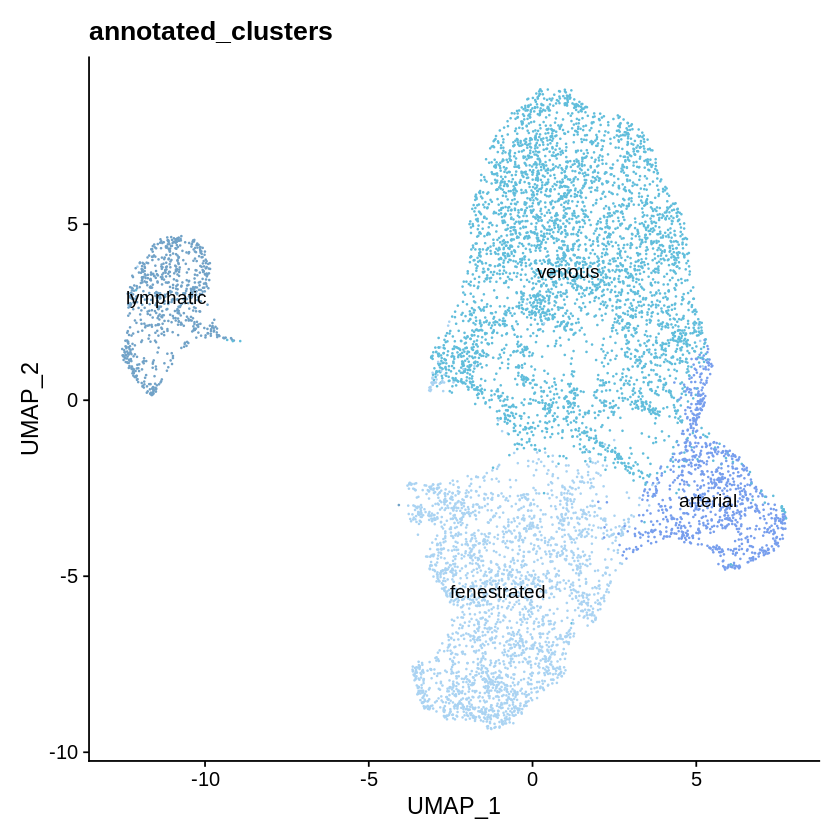

In [36]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_umap_annotated.pdf'), dpi = 75, width = 7, height = 7)

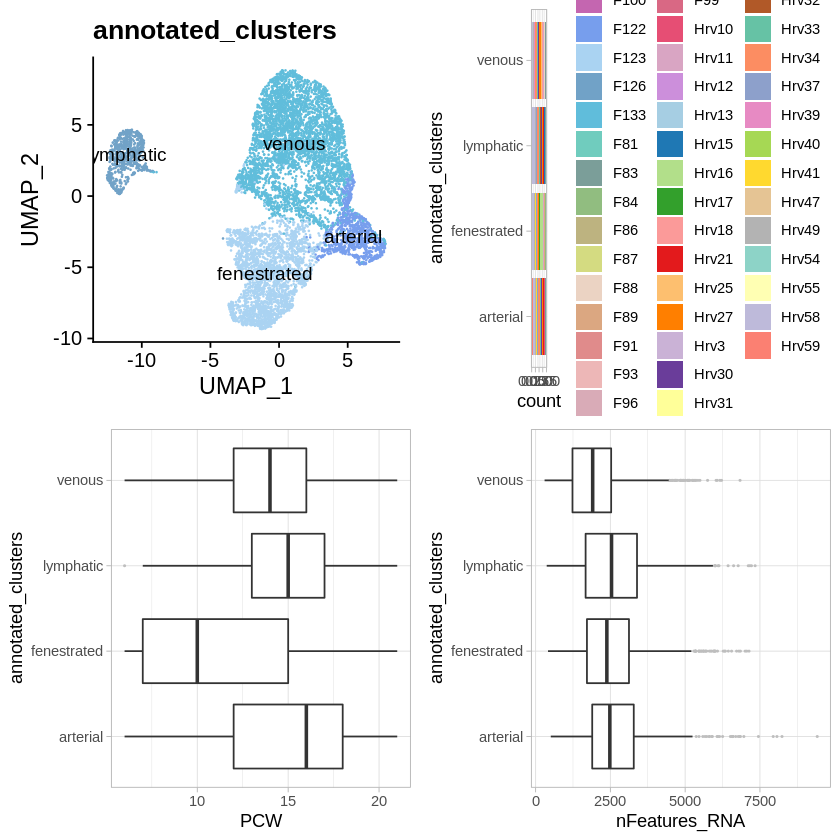

In [37]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = nFeatures_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1b+NoLegend(), b1, b2, b3, ncol = 2)
ggsave(filename = paste0('figures-endothelial/cleanNocycling_metadata_annotated.pdf'), dpi = 75, width = 10, height = 10)

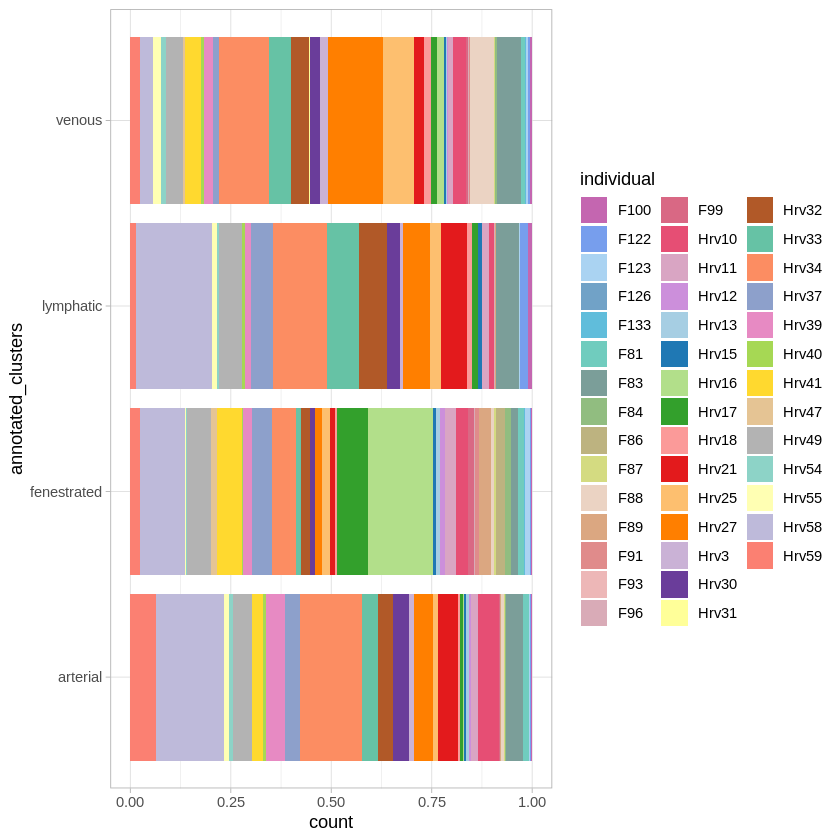

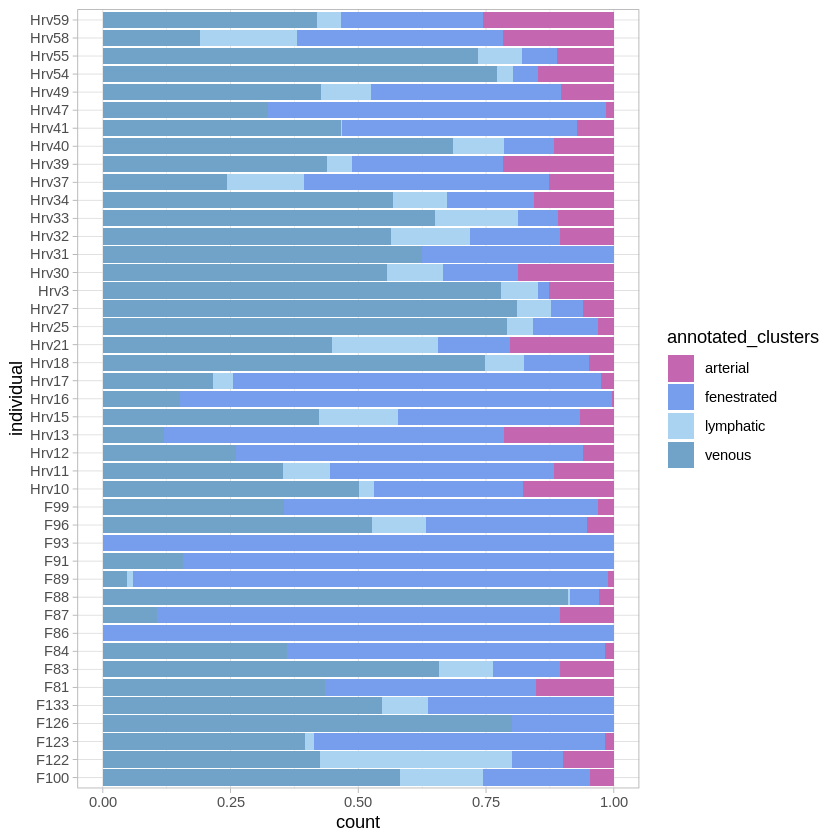

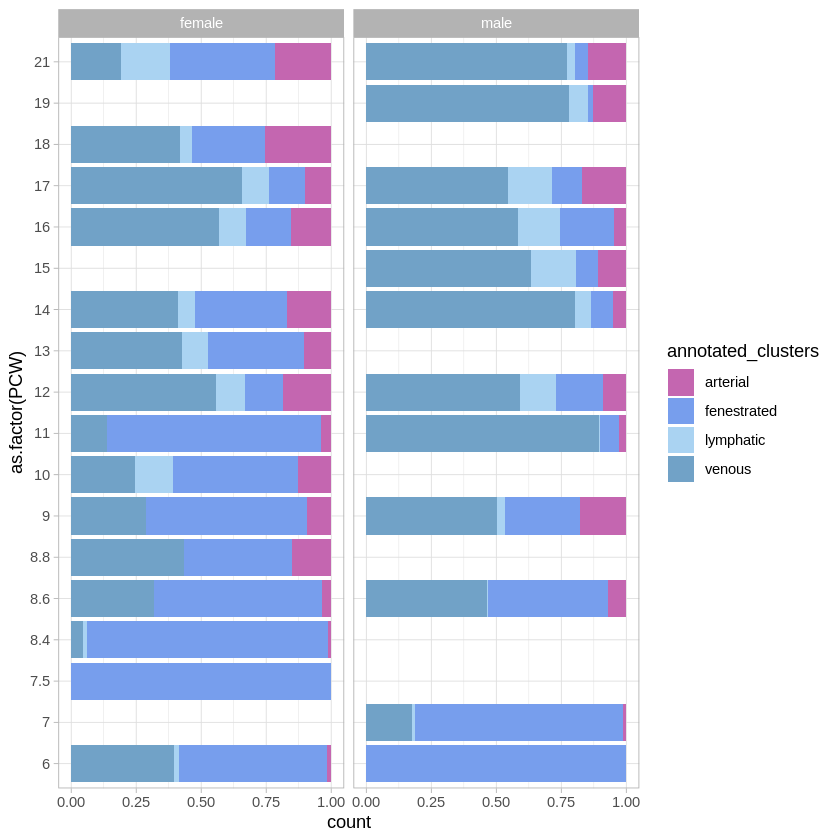

In [38]:
ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = individual , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

# Markers

In [39]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-endothelial/cleanNocycling_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

[1] 400  10

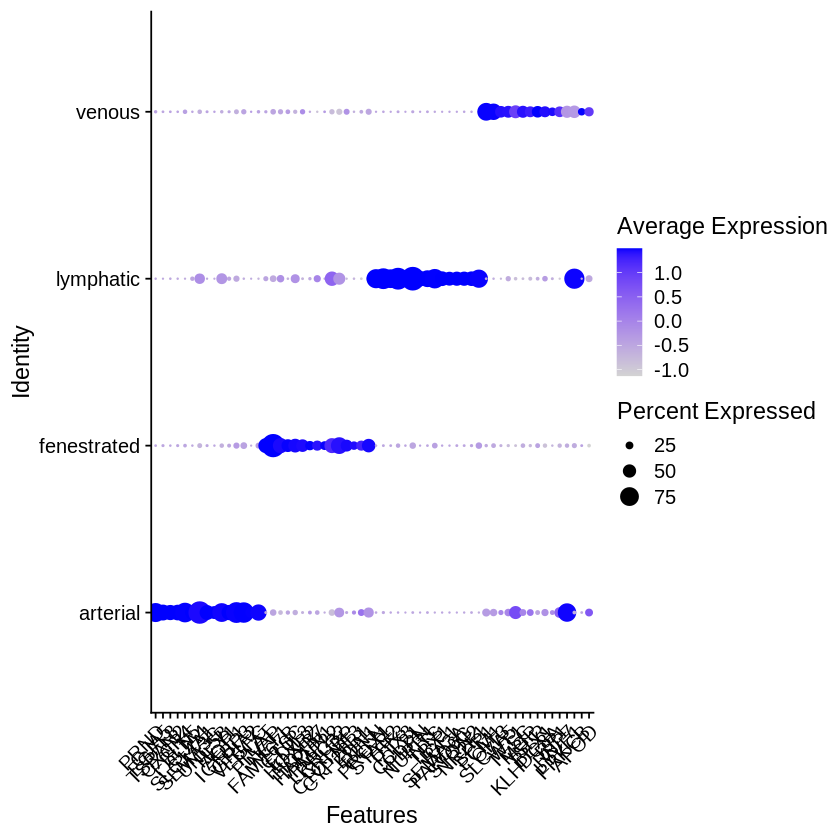

In [40]:
df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

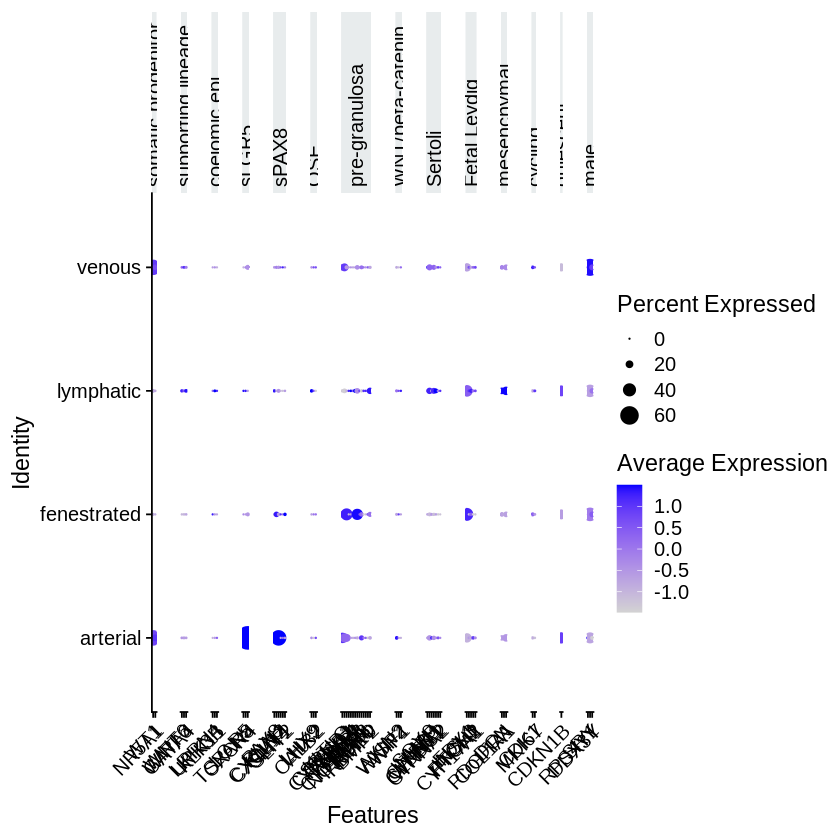

In [41]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

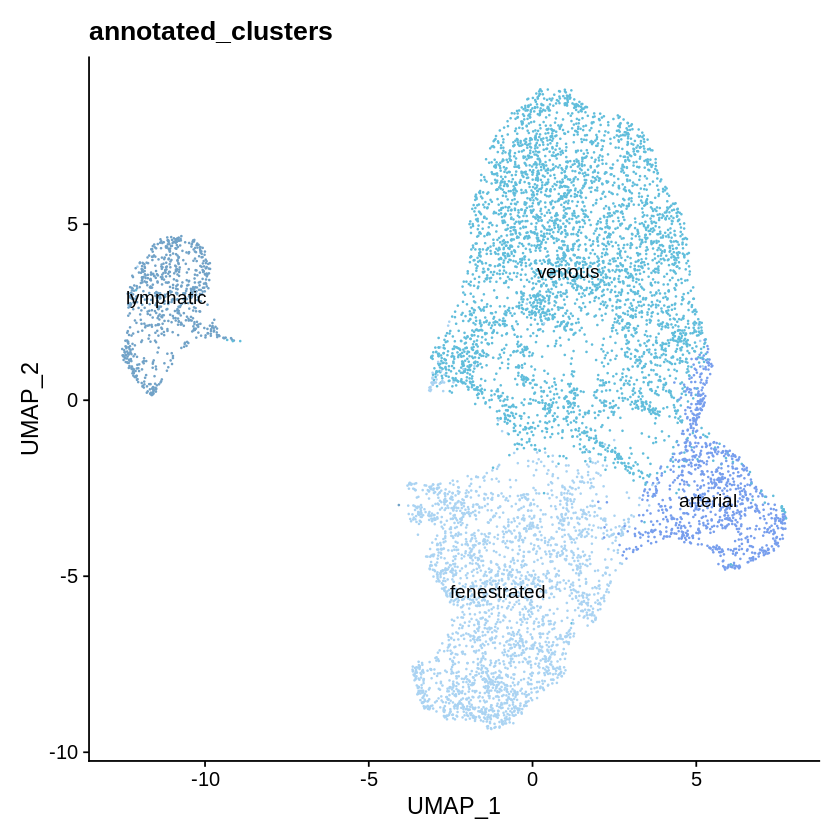

Saving 13.3 x 13.3 in image



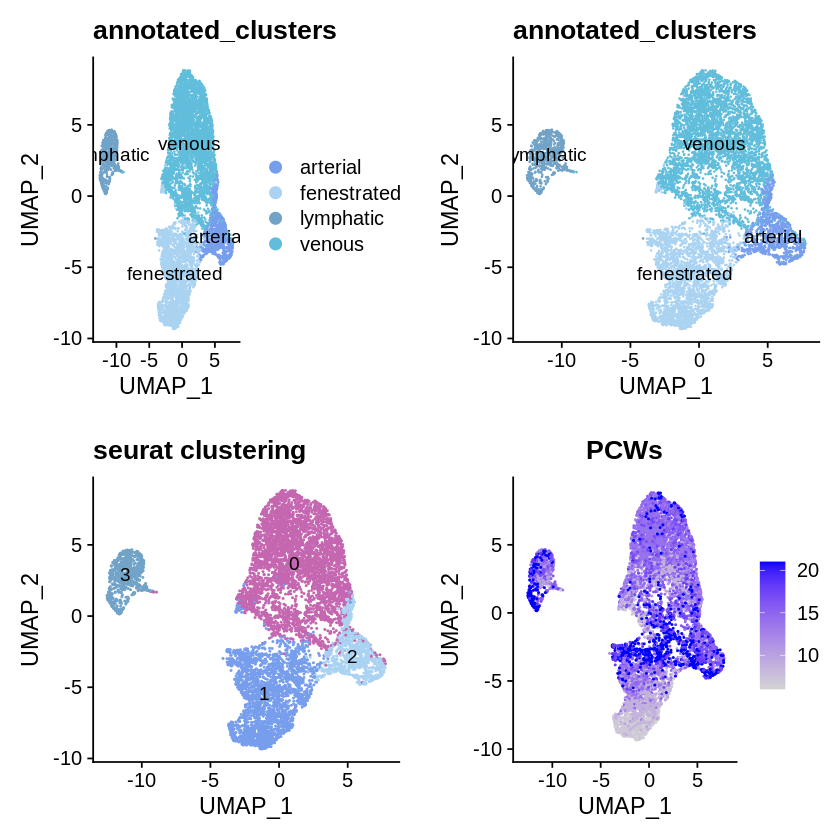

In [42]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()

plot_grid(p1b, p1b+ NoLegend(), p1, p3, ncol = 2)
ggsave(filename = paste0('figures-endothelial/cleanNocycling_umap_annotated.pdf'), dpi = 75, scale = 2)

Saving 10.7 x 10.7 in image



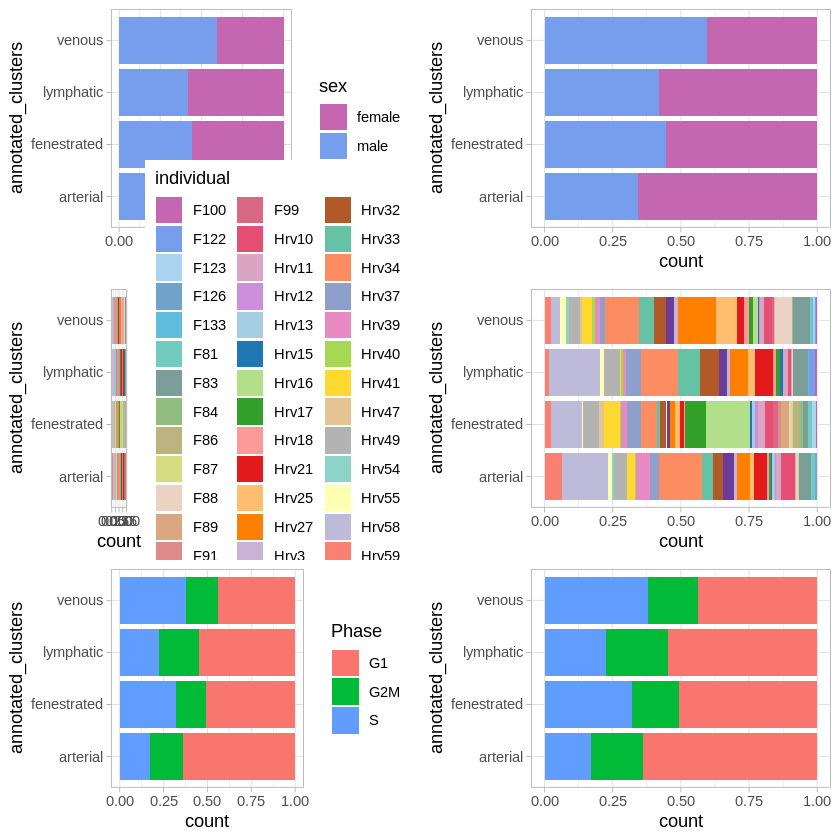

In [43]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()
plot_grid(b1, b1+NoLegend(), b2, b2+NoLegend(),  b3, b3+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-endothelial/cleanNocycling_barplots_annotated.pdf'), dpi = 75, scale = 1.6)

Saving 12 x 6.67 in image



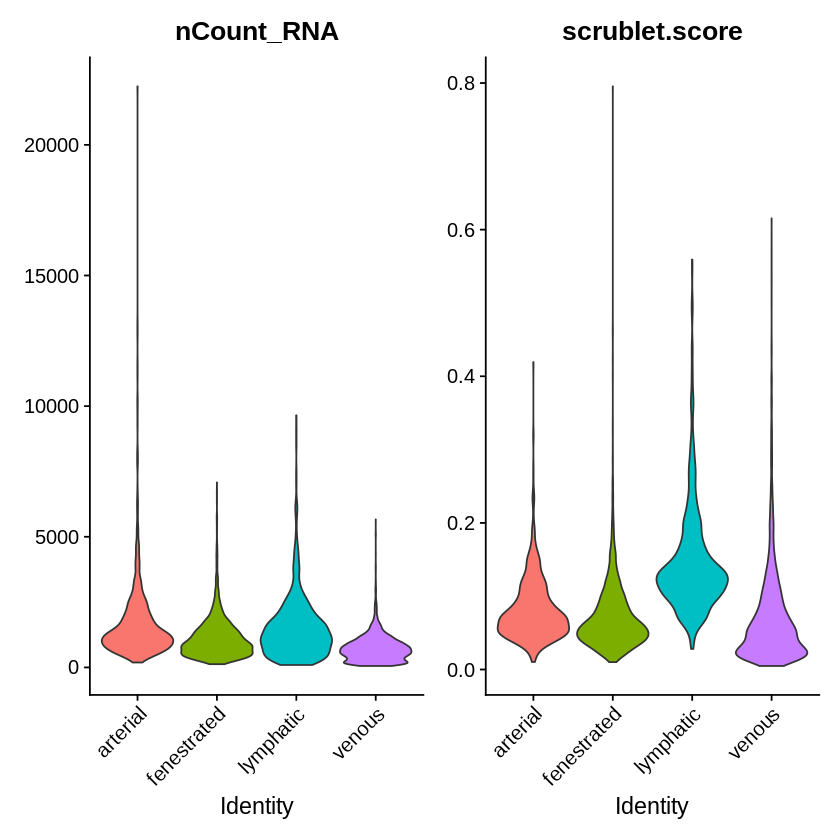

In [44]:
VlnPlot(anndata, c('nCount_RNA', 'scrublet.score'), pt.size = 0)
ggsave(filename = paste0('figures-endothelial/cleanNocycling_boxplots_annotated.pdf'), dpi = 75, width = 12)

# TFIDF and Markers

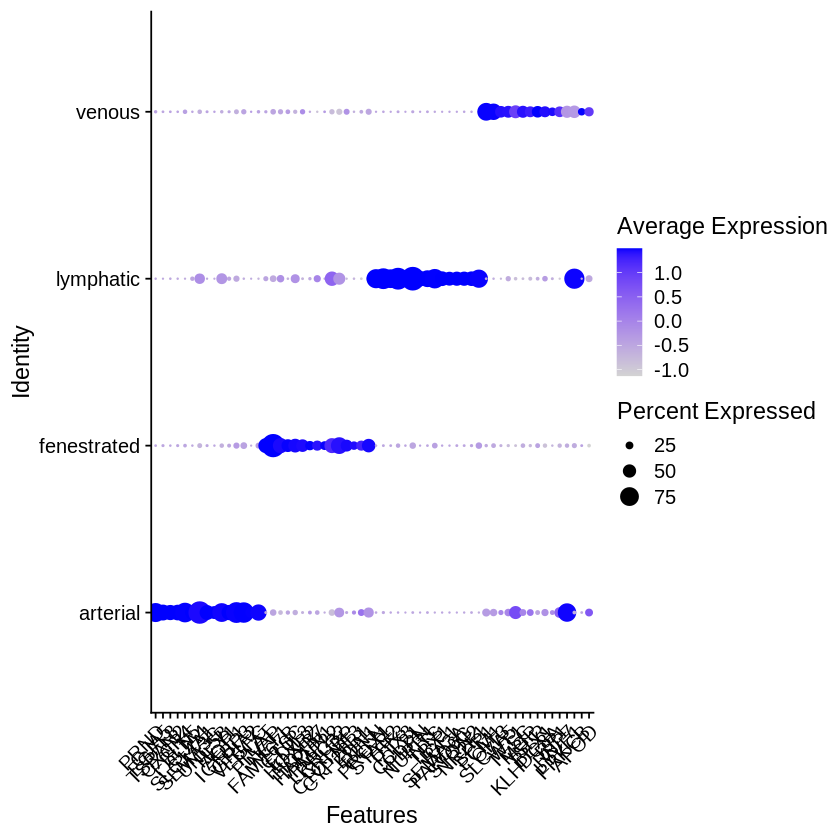

In [45]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
write.csv(df_tfIDF, file = 'figures-endothelial/cleanNocycling_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

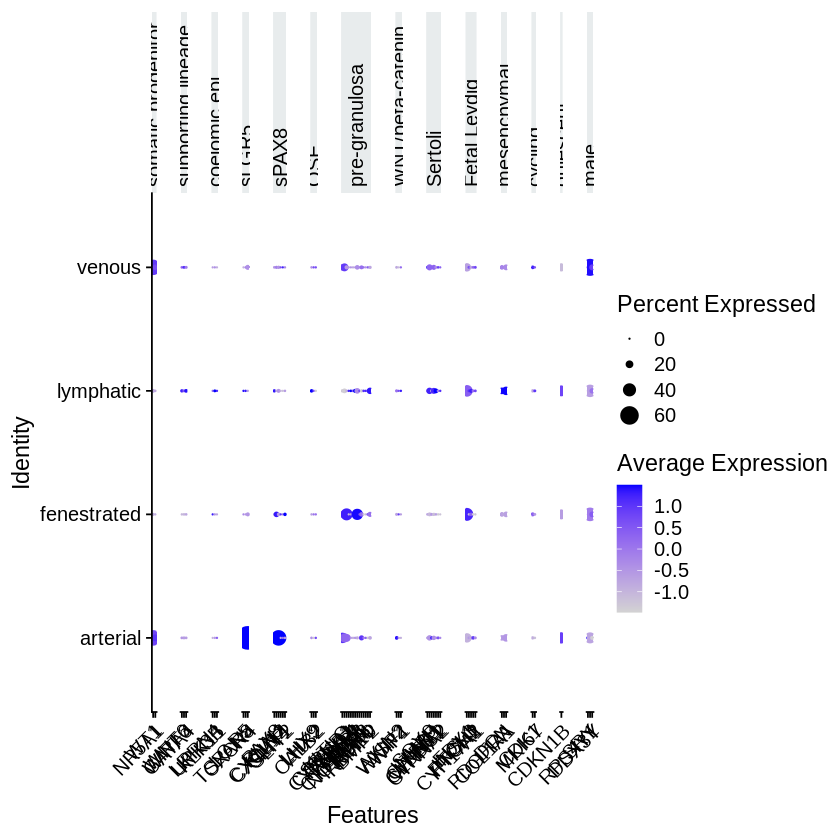

In [46]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

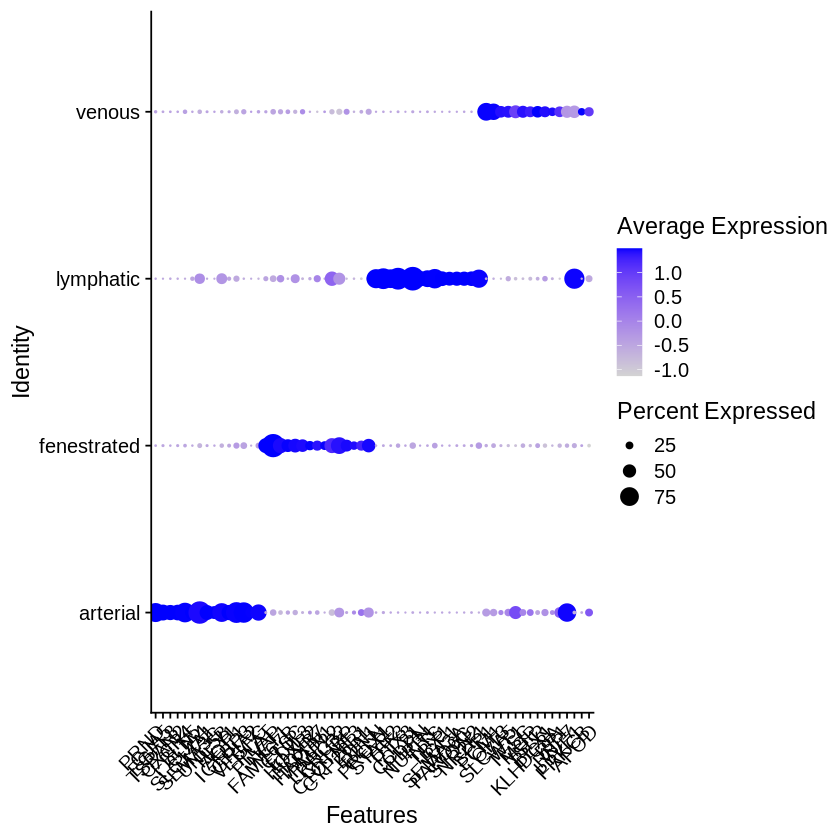

In [48]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters_sex, N = 200)
write.csv(df_tfIDF, file = 'figures-endothelial/cleanNocycling_cluster_markersTFIDF_annotatedSex.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters_sex') + RotatedAxis()
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_TFIDF_DEGs_annotatedSex.pdf'), dpi = 75, height = 5, width = 45)

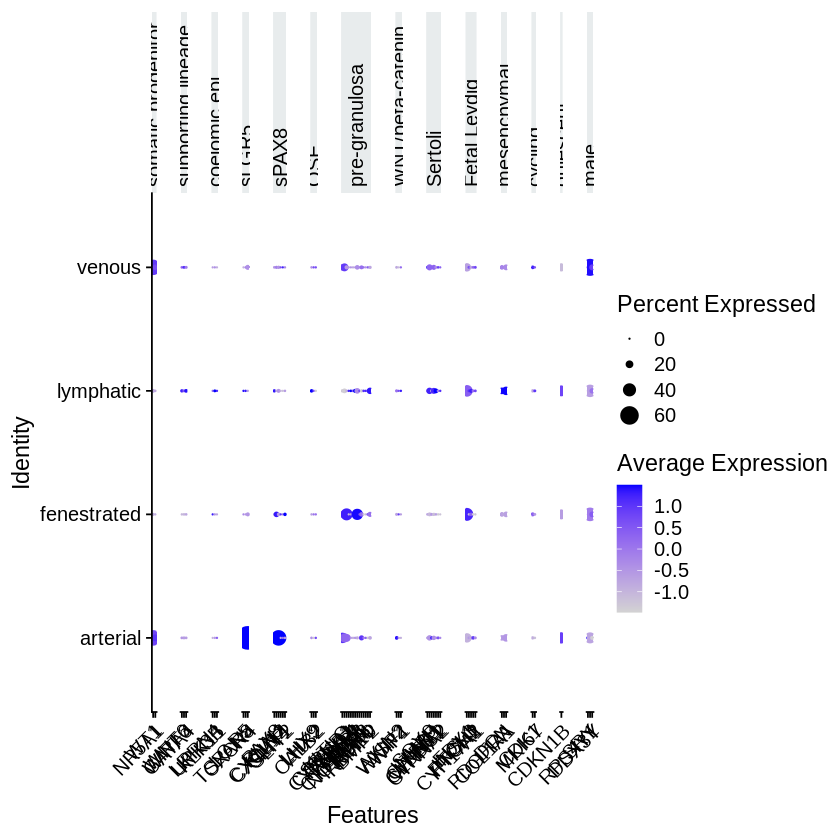

In [49]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters_sex') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-endothelial/cleanNocycling_dotplot_markers_annotatedSex.pdf'), dpi = 75, height = 8, width = 25)

# Save

In [50]:
write.csv(anndata@meta.data, file = paste0('figures-endothelial/annotated_nocycling.csv'), quote = F, row.names = T)
write.csv(anndata@meta.data, file = '/nfs/team292/lg18/with_valentina/endothelial_nocycling_annotation.csv', quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/endothelial_nocycling.rds')

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



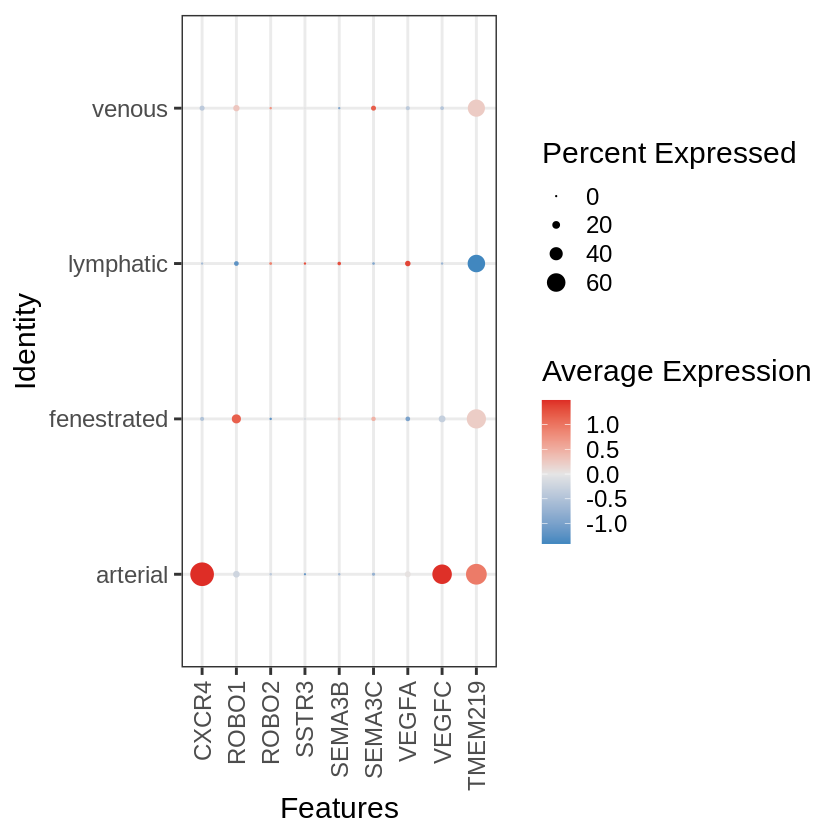

In [53]:
anndataO = subset(anndataO, cells = Cells(anndataO)[ ! anndataO$annotated_clusters %in% c('doublet', 'cycling') ] )
DotPlot(anndataO, features = c('CXCR4',  'ROBO1', 'ROBO2', 'SSTR3', 'SEMA3B','SEMA3C', 'VEGFA', 'VEGFC', 'TMEM219'))  +  
    scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                          high = brewer.pal(n = 5, name = 'Reds')[4], 
                          mid = 'grey90') + theme_bw(18) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
ggsave(filename = paste0('figures-endothelial/0_F2_dotplot_sPAX8_receptors.pdf'), dpi = 75, height = 3, width = 6.5)